In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)



Using TensorFlow backend.


Python:  3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.3
seaborn:  0.9.0
matplotlib:  3.0.3
sklearn:  0.20.3
Keras:  2.2.4
Tensorflow:  1.13.1


In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [10]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)


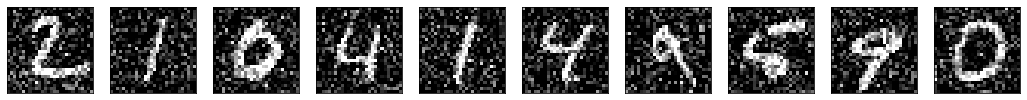

In [11]:
n = 11
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

#cnn autoencoder
logfilename = "DenoisingAutoencoder2"

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [18]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [19]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 13s 212us/step - loss: 0.0370 - acc: 0.8005 - val_loss: 0.0257 - val_acc: 0.8007
Epoch 2/20
60000/60000 [==============================] - 12s 200us/step - loss: 0.0229 - acc: 0.8072 - val_loss: 0.0197 - val_acc: 0.8089
Epoch 3/20
60000/60000 [==============================] - 12s 198us/step - loss: 0.0200 - acc: 0.8091 - val_loss: 0.0190 - val_acc: 0.8107
Epoch 4/20
60000/60000 [==============================] - 12s 193us/step - loss: 0.0185 - acc: 0.8100 - val_loss: 0.0170 - val_acc: 0.8092
Epoch 5/20
60000/60000 [==============================] - 12s 193us/step - loss: 0.0176 - acc: 0.8105 - val_loss: 0.0168 - val_acc: 0.8111
Epoch 6/20
60000/60000 [==============================] - 12s 192us/step - loss: 0.0170 - acc: 0.8108 - val_loss: 0.0163 - val_acc: 0.8114
Epoch 7/20
60000/60000 [==============================] - 11s 191us/step - loss: 0.0164 - acc: 0.8111 - val_loss: 0.

In [20]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 68us/step
Test loss: 0.010875144922733306
Test accuracy: 0.8120423462867736


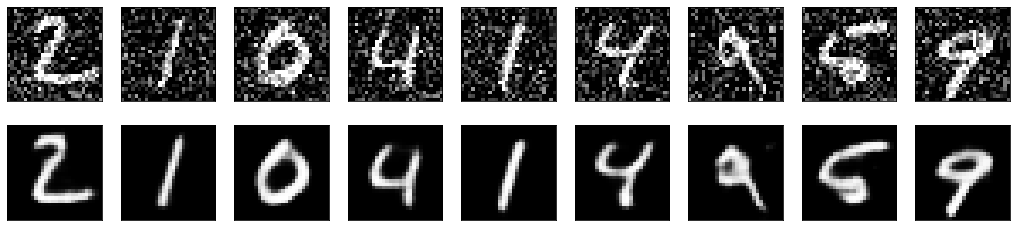

In [27]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

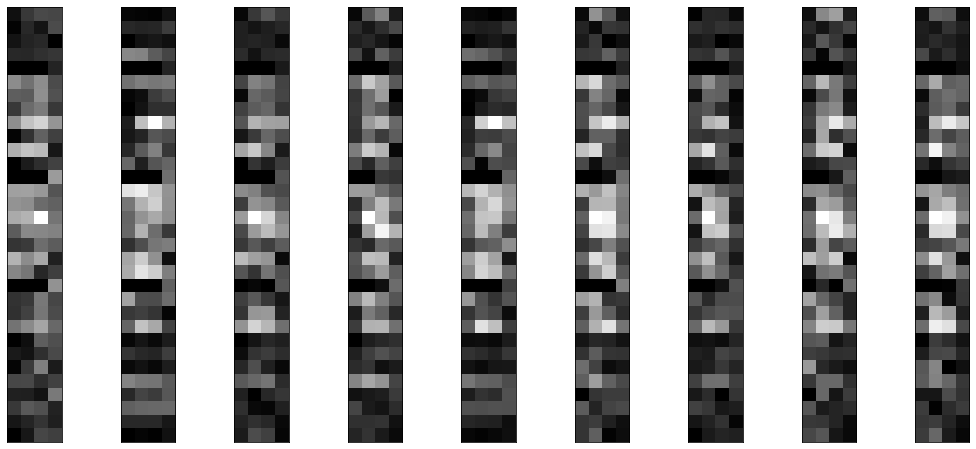

In [29]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()